
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import re

# Bibliotecas para preparação dos dados
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten

#### Importação do dataset buscape

In [3]:
df = pd.read_csv('../datasets/projeto-nlp/buscape.csv')

In [4]:
df = df[['review_text','rating']]

In [5]:
df.head(3)

,review_text,rating
0,"Estou muito satisfeito, o visor é melhor do qu...",4
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",5
2,"Rápida, ótima qualidade de impressão e fácil d...",5


In [6]:
df.shape

(84991, 2)

#### Tarefa: Classificação de ratings das avaliações de clientes:
- 4 e 5: Positiva
- 1 e 2: Negativa
- 3: Descartadas


#### Pré-processamento

#### Verificando registros nulos

In [7]:
df.isnull().any()

review_text     True
rating         False
dtype: bool

In [8]:
df['review_text'].isnull().sum()

1

In [9]:
df[df['review_text'].isnull()]

,review_text,rating
38852,NaN,4


#### Removendo registros nulos

In [10]:
df = df.dropna()

In [11]:
df.isnull().any()

review_text    False
rating         False
dtype: bool

In [12]:
df.shape

(84990, 2)

#### Padronizando texto em lowercase

In [13]:
def to_lowercase(text):
    text = text.apply(lambda x: " ".join(x.lower().split()) if isinstance(x, str) else "")
    return text

In [14]:
df["review_text"] = to_lowercase(df["review_text"])

In [15]:
df.head(3)

,review_text,rating
0,"estou muito satisfeito, o visor é melhor do qu...",4
1,"""muito boa o que gostei: preco o que não goste...",5
2,"rápida, ótima qualidade de impressão e fácil d...",5


#### Removendo caracteres especiais e substituindo cedilhas por c

In [16]:
df['review_text'][14]

'fragrância leve e fixação duradoura.. adoroooo esse perfume'

In [17]:
def preprocess_text(text):
    # removendo caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    # unidecode translitera caracteres acentuados e especiais para formas sem acento ou caracteres equivalentes
    text = unidecode(text)
    return text

In [18]:
df['review_text'] = [preprocess_text(doc) for doc in df['review_text']]

In [19]:
df['review_text'][14]

'fragrancia leve e fixacao duradoura adoroooo esse perfume'

#### Removendo hiperlinks

In [20]:
def remove_hiperlink(text):
    text = re.sub(r"(https?://[^\s]+|www\.[^\s]+)", '', text)
    return text

In [21]:
df['review_text'] = [remove_hiperlink(doc) for doc in df['review_text']]

#### Descartando instâncias com avaliação igual a 3

In [22]:
rating_3 = df['rating'] == 3
rating_3.sum()

11364

In [23]:
df = df[df['rating'] != 3]

In [24]:
df.shape

(73626, 2)

#### Ajustando ratings:
- 1 e 2 = 0
- 4 e 5 = 1

In [25]:
df['rating'] = list(map(lambda x: 0 if x<=2 else 1, df['rating']))

In [26]:
df_count = df['rating'].value_counts()
print(f'{df_count[1]} Avaliações Positivas')
print(f'{df_count[0]} Avaliações Negativas')

66816 Avaliações Positivas
6810 Avaliações Negativas


#### Nota-se que o dataset está desbalanceado

In [27]:
def plot_barchart(data):
    rating_counts = data
    labels = [f'{data[1]} Avaliações Positivas', f'{data[0]} Avaliações Negativas']

    # Criar o gráfico de barras
    plt.bar(labels, rating_counts)

    # Adicionar rótulos e título
    plt.xlabel('Ratings')
    plt.ylabel('Contagem')
    plt.title('Gráfico de Barras de Ratings')

    # Mostrar o gráfico
    plt.show()

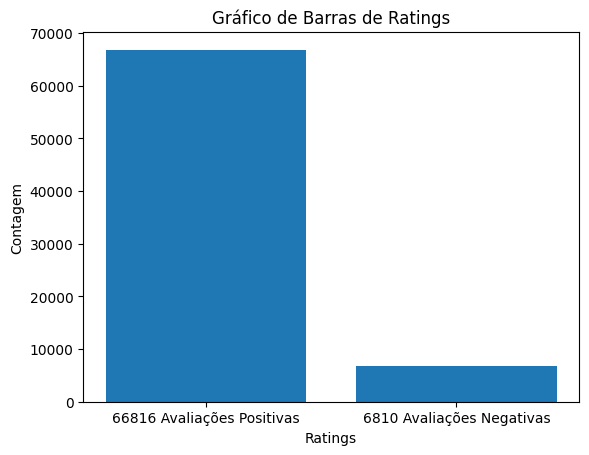

In [30]:
plot_barchart(df_count)

#### Utilizar a técnica de reamostragem RandomOverSampler para resolver o problema de desbalanceamento das classes
- Esta técnica gera novas amostras aleatórias para a classe minoritária;
- Desta forma tenta igualar número de amostras da classe majoritária;

In [28]:
from imblearn.over_sampling import RandomOverSampler

In [29]:
# Gerando uma cópia do dataset
df_balanced = df.copy()

In [30]:
# Criando uma instância do RandomOverSampler
ros = RandomOverSampler()

#### Separarando os recursos (X) e os rótulos (y)

In [31]:
# Alterarando o shape dos dados para uma representação com uma única coluna
# Os dados foram mantidos, mas agora X possui uma coluna adicional, tornando-se uma matriz bidimensional em vez de uma matriz unidimensional
X = np.array(df_balanced['review_text'])
X = X.reshape(-1, 1)

In [32]:
y = df_balanced['rating']

In [33]:
# Aplicando o RandomOverSampler para gerar novas amostras
X_res, y_res = ros.fit_resample(X, y)

In [34]:
print(pd.Series(y_res).value_counts())

rating
1    66816
0    66816
Name: count, dtype: int64


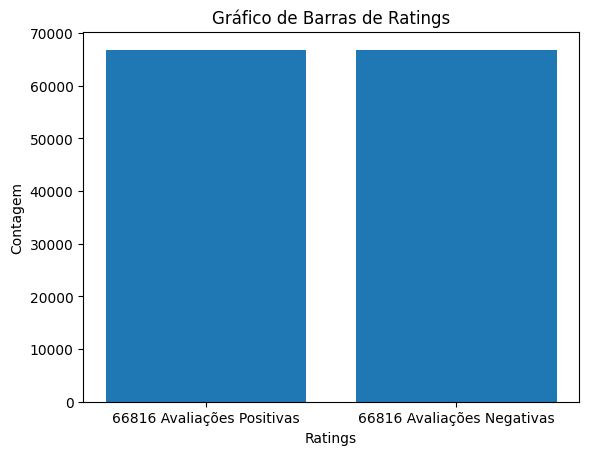

In [38]:
plot_barchart(y_res.value_counts())

#### Tokenização
- O Tokenizer é usado para converter o texto em uma sequência de números, criando um dicionário de palavras únicas presentes no texto e mapeando cada palavra para um índice inteiro. Esse processo é chamado de tokenização.

In [35]:
corpus = df_balanced['review_text']

In [36]:
# Criando uma instância do Tokenizer
#vocab_size=16000
#tokenizer = Tokenizer(num_words=vocab_size)
tokenizer = Tokenizer()

In [37]:
# Ajustando o Tokenizer ao corpus
tokenizer.fit_on_texts(corpus)

In [38]:
# Obtendo o dicionário de palavras únicas e seus índices
word_index = tokenizer.word_index

In [39]:
# Tamanho do dicionário
len(word_index)

71829

In [40]:
# Obtendo as sequências de índices para os textos do corpus
sequences = tokenizer.texts_to_sequences(corpus)

In [41]:
X = pad_sequences(sequences, truncating='post', padding='post')

In [42]:
# Tamanho do vetor após aplicacão do pad_sequences
len(X[0])

844

In [43]:
# Carregando os vetores GloVe
glove_file = '../embeddings/glove.6B.50d.txt'

In [51]:
word_to_embedding = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        
        # Tratando a substituição da vírgula por ponto no vetor de embedding
        if ',' in values[1]:
            embedding = [float(val.replace(',', '.')) for val in values[1:]]
        
        word_to_embedding[word] = embedding

In [53]:
# Definindo o tamanho do vocabulário e o tamanho dos vetores de embedding
vocab_size = len(word_to_embedding)
print(f'tamanho do vocabulário: {vocab_size}')
embedding_size = len(list(word_to_embedding.values())[0])
print(f'tamanho do embedding: {embedding_size}')

tamanho do vocabulário: 400000
tamanho do embedding: 50


In [54]:
# Criando a matriz de embedding que será usada na camada Embedding da rede neural
embedding_matrix = np.zeros((vocab_size, embedding_size))

In [55]:
for i, word in enumerate(word_to_embedding):
    embedding_matrix[i] = word_to_embedding[word]

#### Dividindo o dataset

In [56]:
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#### Verificando quantidade de instâncias e tamanho do vetor

In [100]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (58900, 844)
X_test: (14726, 844)
y_train: (58900,)
y_test: (14726,)


#### Iniciando arquitetura da MLP

In [117]:
model = Sequential()
#weights=[embedding_matrix]
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=844))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 844, 50)           20000000  
                                                                 
 dense_6 (Dense)             (None, 844, 24)           1224      
                                                                 
 dropout_2 (Dropout)         (None, 844, 24)           0         
                                                                 
 dense_7 (Dense)             (None, 844, 1)            25        
                                                                 
Total params: 20,001,249
Trainable params: 20,001,249
Non-trainable params: 0
_________________________________________________________________


In [118]:
LEARNING_RATE = 5e-4
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['acc']
BATCH_SIZE = 32
EPOCHS = 10
CALLBACKS = [tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]

In [119]:
# Compilando o modelo
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER, 
    metrics=METRICS
)

In [ ]:
# Treinando o modelo
model_history = model.fit(
    X_train, 
    y_train, 
    verbose=1, 
    batch_size=BATCH_SIZE,  
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=CALLBACKS
)

Epoch 1/10
  39/1841 [..............................] - ETA: 11:20 - loss: 0.6542 - acc: 0.8074

In [64]:
NB_START_EPOCHS = 9  # Número de épocas

In [65]:
def eval_metric(history, metric_name):
    '''
    Função para avaliar o modelo treinado na métrica escolhida. 
    Treino e valição são plotados por época.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

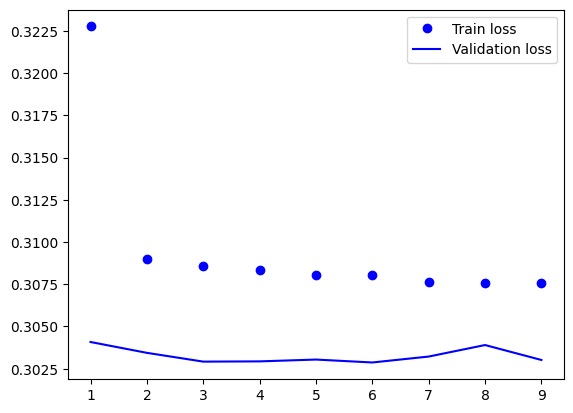

In [66]:
eval_metric(model_history, 'loss')

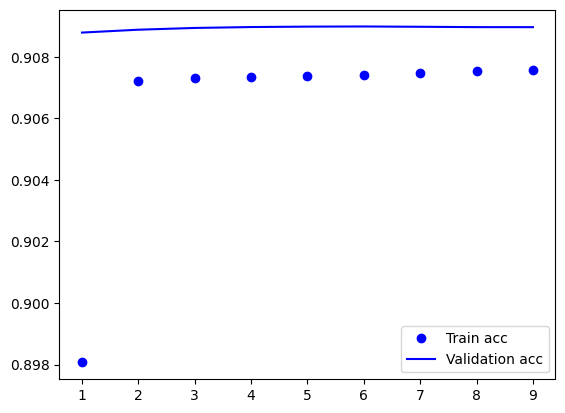

In [67]:
eval_metric(model_history, 'acc')

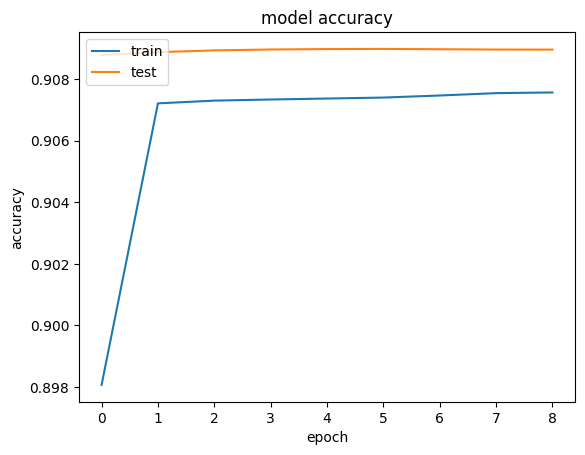

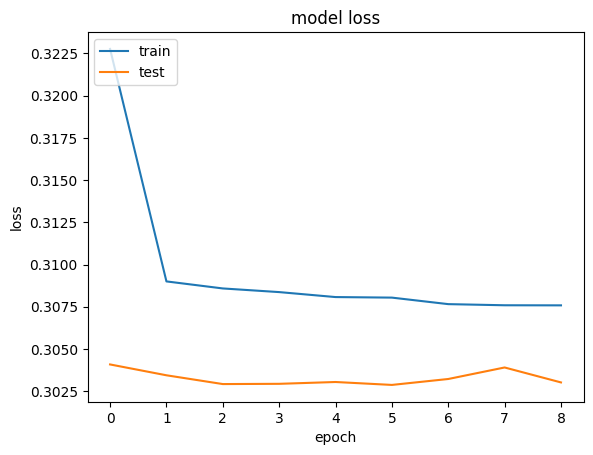

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
predicao = np.round(model.predict(X_test))

461/461 [==============================] - 11s 24ms/step


In [107]:
acc = accuracy_score(y_test, predicao)

ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [74]:
acc

NameError: name 'acc' is not defined

In [75]:
print(classification_report(y_test, predicao))

ValueError: Classification metrics can't handle a mix of binary and unknown targets

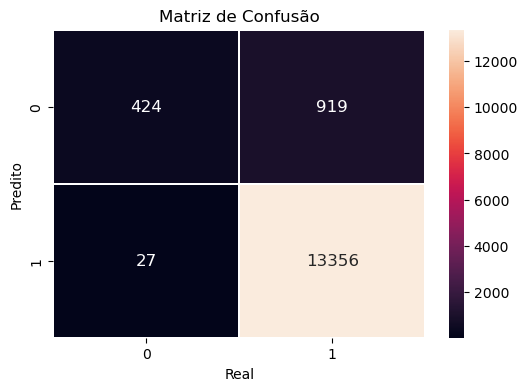

In [125]:
mc = confusion_matrix(y_test, predicao)
plt.figure(figsize=(6,4))
sbn.heatmap(mc, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
plt.title("Matriz de Confusão", fontsize=12)
plt.xlabel('Real')
plt.ylabel('Predito')
plt.show()